Transformer的结构如下图所示：


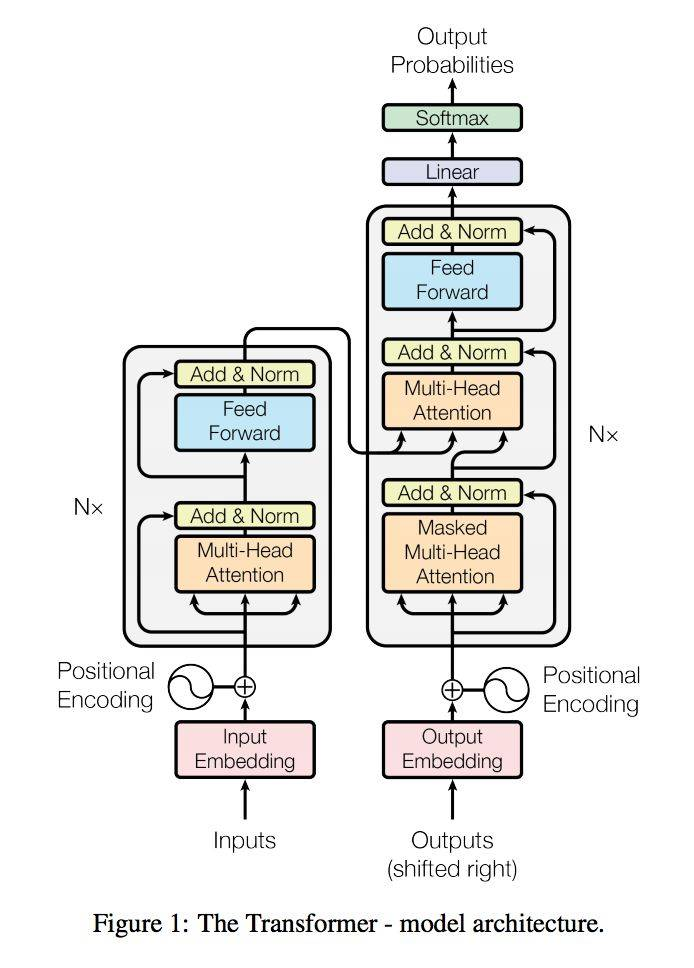

In [2]:
from IPython.display import Image
Image(filename="../img/4.jpg", width=400, height=400)

transformer模型由encoder和decoder两部分组成.  
上图的左半边用Nx框出来的，就是我们的encoder的一层。encoder一共有6层这样的结构。  
上图的右半边用Nx框出来的，就是我们的decoder的一层。decoder一共有6层这样的结构。
  
  
输入序列经过word embedding和positional encoding相加后，输入到encoder中。  
输出序列经过word embedding和positional encoding相加后，输入到decoder中。  
最后，decoder输出的结果，经过一个线性层，然后计算softmax。


Encoder：  
    encoder由6层相同的层组成，每一层分别由两部分组成：  
    1、第一部分是一个multi-head self-attention mechanism。  
    2、第二部分是一个position-wise feed-forward network，是一个全连接层。
    
 两个部分，都有一个残差连接，然后接着一个Layer Normalization.
 

Decoder：  
  和encoder类似，decoder由6个相同的层组成，每一个层包括以下三个部分：  
      1、第一个部分是multi-head self-attention mechanism.  
      2、第二个部分是multi-head context-attention mechanism.  
      3、第三个部分是一个position-wise feed-forward network.
    
 还是和encoder类似，上面三个部分的每一个部分，都有一个残差连接，后接Layer Normalization.  
 
 但是decoder中出现了一个新的东西multi-head context-attention mechanism。




Attention：  

    transformer模型中使用的attention机制是乘性注意力(multiplicative attention)，也就是两个向量进行点积。
    
Self-attention：  

    一般的attention机制会有两个隐状态，假如是hi和si，前者是输入序列第i个位置产生的隐状态，后者是输出序列在第t个位置产生的隐状态。
    所谓的self-attention实际上就是，输出序列就是输入序列，因此计算自己的attention得分，就叫做self-attention。
    
Context-attention：  

    它是encoder和decoder之间的attention，所以也可以把它称为encoder-decoder attention，它的实质其实就是两个不同序列间的attention。

不管是self-attention还是context-attention，它们计算attention分数时，可以选择多种方式，如下：  
 1、additive attention；  
 2、location-base；  
 3、general；  
 4、dot-product；  
 5、scaled dot-product； 
 

transformer中采取的attention是--scaled dot-product attention。

attention的几种计算分值方式如下表所示：

    

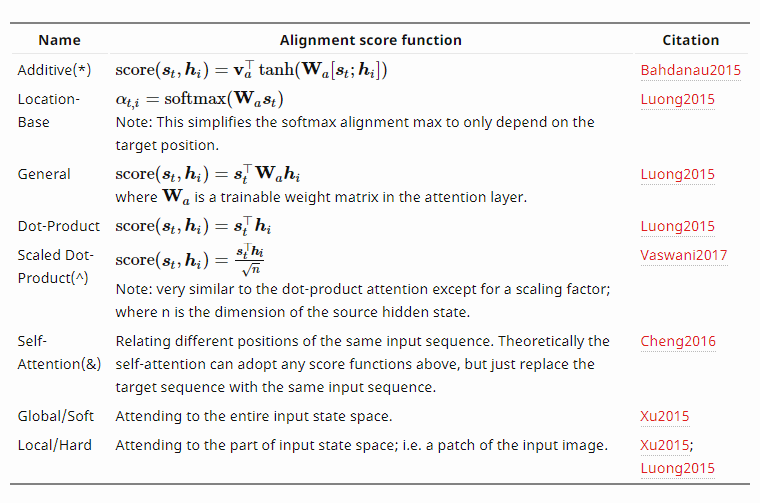

In [3]:
from IPython.display import Image
Image(filename="../img/5.png", width=400, height=400)

Scaled dot-product attention是什么：论文中的描述是这样的，
”An attention function can be described as a query and a set of key-value pairs to an output, 
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, 
where the weight assigned to each value is computed by a compatibility of the query with the corresponding key.”

这句话的核心思想就是：通过确定Q和K之间的相似程度来选择V。
用公式来描述就是：

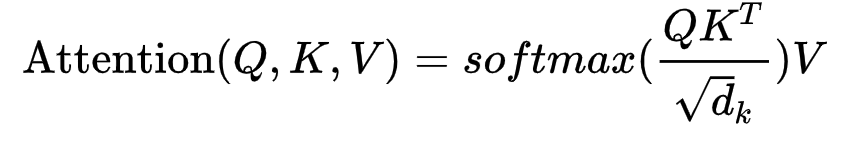

In [4]:
from IPython.display import Image
Image(filename="../img/6.png", width=400, height=400)

In [4]:
#Scaled dot-product attention的实现
#这里最后返回的是融合attention后的一个Value值


import torch
import torch.nn as nn

class ScaledDotProductAttention(nn.Module):
    "Scaled dot-product attention mechanism"
    
    def __init__(self, attention_dropout=0.0):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.softmax(dim=2)
        
    def forward(self,q,k,v, scale=None, attn_mask=None):
        """
        前向传播
        
        Args：
            q: Queries张量，形状为[B, L_q, D_q]
            k: Keys张量，形状为[B, L_k, D_k]
            v: Values张量，形状为[B, L_v, D_v]，一般来说v和k是相同的
            scale：缩放因子，一个浮点标量
            attn_mask：Masking张量，形状为[B, L_q, L_k]
            
        Returns：
            上下文张量和attention张量
        
        """

        attention = torch.bmm(q, k.transpose(1,2))
        #attention的维度是[B,L_q,L_k]
        if scale:
            #这里的scale就是上面公式中的根号dk分之一
            attention = attention * scale
        if attn_mask:
            #给需要mask的地方设置一个负无穷,设置负无穷后，他们softmax后对应的值几乎为0
            attention = attention.masked_fill_(attn_mask, -np.inf)
        #计算softmax
        attention = self.softmax(attention)
        #添加dropout
        attention = self.dropout(attention)
        #和V做点积
        context = torch.bmm(attention, v)
        
        
        return context, attention



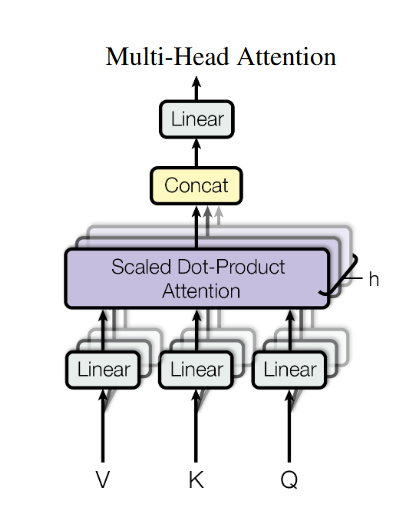

In [5]:
from IPython.display import Image
Image(filename="../img/7.png", width=400, height=400)

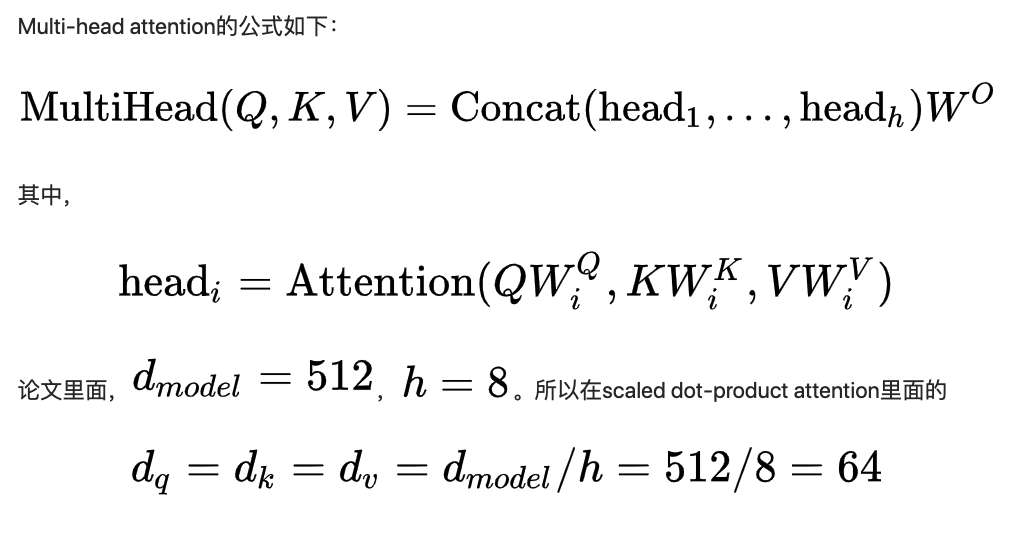

In [6]:
from IPython.display import Image
Image(filename="../img/8.png", width=400, height=400)

In [7]:
#Multi-head attention的实现

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    
    def __init__(self, model_dim=512, num_heads=8, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        
        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_v = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_q = nn.Linear(model_dim, self.dim_per_head * num_heads)
        
        self.dot_product_attention = ScaledDotProductAttention(dropout)
        self.linear_final = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        
        #multi-head之后需要做layer norm
        self.layer_norm = nn.LayerNorm(model_dim)


    def forward(self, key, value, query, attn_mask=None):
        #残差连接
        residual = query
        
        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        batch_size = key.size(0)
        
        #linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)
        
        #split by heads
        #这里输入的q,k,v的维度是[Batch, L_q, dim]，经过view后的维度变成了[Batch*num_heads, L_q, dim_per_head]
        #所以这里的所谓划分多个head，其实运用到矩阵中，就是把最后一维切分后再view到第一维，
        #因为最后计算scaledDotProduction时，具体实现也是最后两维组成的二维矩阵进行乘积计算，然后得到[Batch,L_q,L_k]的attention矩阵
        #所以我理解这里的划分head_num,其实是用embedding维度的前64位相互计算一个attention分布，再用紧接着的64维计算等，
        #可以理解为不同的embed_dim代表着不同的语义信息？？？
        
        key = key.view(batch_size*num_heads, -1, dim_per_head)
        value = value.view(batch_size*num_heads, -1, dim_per_head)
        query = query.view(batch_size*num_heads, -1, dim_per_head)
        

        if attn_mask:
            attn_mask = attn_mask.repeat(num_heads, 1, 1)
            
        #scaled dot product attention
        scale = (key.size(-1) // num_heads) ** -0.5
        context, attention = self.dot_product_attention(query, key, value, scale, attn_mask)
        
        #concat heads
        context = context.view(batch_size, -1, dim_per_head*num_heads)
        
        #final linear projection
        output = self.linear_final(context)
        
        #dropout
        output = self.dropout(output)
        
        #add residual and norm layer
        
        #这里进行layer_norm之前先加上了residual
        output = self.layer_norm(residual + output)
        
        return output, attention
    
            
        
        



In [18]:
#Padding mask的实现
def padding_mask(seq_k, seq_q):
    #seq_k和seq_q的形状都是[B,L]
    len_q = seq_q.size(1)
    
    #Padding位置都是0
    pad_mask = seq_k.eq(0)
    #shape为[B, L_q, L_k]
    pad_mask = pad_mask.unsqueeze(1).expand(-1, len_q, -1)
    return pad_mask



In [23]:
#这部分代码是为了测试padding_mask的功能
import torch

seq_src = torch.tensor([[2,2,1,1],[3,3,2,1]])
seq_tgt = torch.tensor([[2,2,2,2],[3,3,3,3]])
print(seq_src.size())

len_tgt = seq_tgt.size(1)

pad_mask = seq_src.eq(1)
print(pad_mask)

#torch.unsequeeze(dim)现在第dim维度增加一个为1的维度，然后用expand将它进行复制扩张
res = pad_mask.unsqueeze(1).expand(-1, len_tgt, -1)
print(res)
print(res.size())




torch.Size([2, 4])
tensor([[0, 0, 1, 1],
        [0, 0, 0, 1]], dtype=torch.uint8)
tensor([[[0, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]], dtype=torch.uint8)
torch.Size([2, 4, 4])


In [9]:
def sequence_mask(seq):
    batch_size, seq_len = seq.size()
    mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.uint8), diagonal=1)
    #维度为[B,L,L]
    mask = mask.unsqueeze(0).expand(batch_size, -1,-1)
    return mask







In [10]:
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
b = torch.triu(torch.ones((3,3)), diagonal=1)
print("b is:",b)
b = b.unsqueeze(0).expand(3,-1,-1)
print("b is:",b)


a = torch.tensor([[1,2,3]])
b = torch.tensor([[0,1,1],[0,0,1],[0,0,0]])
c = torch.mm(a,b)
print("c is:",c)

b is: tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])
b is: tensor([[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]]])
c is: tensor([[0, 1, 3]])


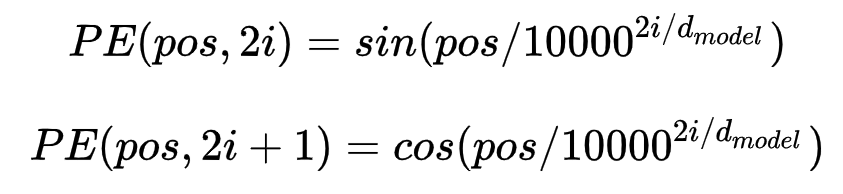

In [7]:
from IPython.display import Image
Image(filename="../img/9.png", width=400, height=400)

In [12]:
#Positional encoding的实现

import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_seq_len):
        """
        初始化
        Args：
            d_model：一个标量，模型的维度，论文默认的是512.
            max_seq_len：一个标量。文本序列的最大长度
        
        """
        super(PositionalEncoding, self).__init__()
        
        #根据论文给的公式，构造出PE矩阵
        position_encoding = np.array([[pos/np.pow(10000, 2.0*(j//2)/d_model) for j in range(d_model)] for pos in range(max_seq_len)])
        #偶数列使用sin，奇数列使用cos
        position_encoding[:, 0::2] = np.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = np.cos(position_encoding[:, 1::2])
        
        #在PE矩阵的第一行，加上一行全是0的向量，代表着"PAD"的positional encoding，这里没弄太明白为什么不是在第一列加
        #在word embedding中也经常会加上“UNK”，代表着位置单词的word embedding，两者很类似
        #那么我们为什么需要这个额外的PAD的编码呢，很简单，因为文本序列的长度不一，我们需要对齐
        #短的序列我们使用0在结尾补全，我们也需要这些补全位置的编码，也就是“PAD”对应的位置编码
        pad_row = torch.zeros([1, d_model])
        position_encoding = torch.cat((pad_row, position_encoding))
        
        #嵌入操作，+1是因为增加了“PAD”这个补全位置的编码
        #word embedding中如果词典增加"UNK"，我们也需要+1
        self.position_encoding = nn.Embedding(max_seq_len+1, d_model)
        self.position_encoding.weight = nn.Parameter(position_encoding, requires_grad=False)

        
    def forward(self, input_len):
        """
        神经网络的前向传播
        
        Args：
            Input_len：一个张量，形状为[batch_size,1]，每一个张量的值代表这一批文本序列中对应的长度。
            
        Returns：
            返回这一批序列的位置编码，进行了对齐
        
        """
        
        #找出这一批序列的最大长度
        max_len = torch.max(input_len)
        tensor = torch.LongTensor
        #对每一个序列的位置进行对齐，在原序列位置的后面补0
        #这里的range从1开始也是因为要避开PAD(0)的位置
        input_pos = tensor([list(range(1, len+1)) + [0]*(max_len - len) for len in input_len])
        return self.position_encoding(input_pos)
        
        


In [13]:
a = torch.ones(10,5)
print(a)
b = torch.zeros(1,5)
c = torch.cat((b,a))
print(c)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [14]:
import torch
import torch.nn as nn

class PositionalWiseFeedForward(nn.Module):
    
    def __init__(self, model_dim=512, ffn_dim=2048, dropout=0.0):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Conv1d(model_dim, ffn_dim, 1)
        self.w2 = nn.Conv1d(model_dim, ffn_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)
        
    def forward(self, x):
        output = x.transpose(1,2)
        output = self.w2(F.relu(self.w1(output)))
        output = self.dropout(output.transpose(1,2))
        
        #增加残差和norm layer
        output = self.layer_norm(x + output)
        return output
        
        
        
        
        

In [15]:
#encoder的代码实现如下
import torch
import torch.nn as nn

class EncoderLayer(nn.Module):
    """
    Encoder的一层
    
    """

    def __init__(self, model_dim=512, num_heads=8, ffn_dim=2048, dropout=0.0):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        
    def forward(self, inputs, attn_mask=None):
        
        #self attention
        context, attention = self.attention(inputs, inputs, inputs, padding_mask)
        
        #feed forward network
        output = self.feed_forward(context)
        
        return output, attention

class Encoder(nn.Module):
    """
    多层的EncoderLayer组成Encoder
    """
    
    def __init__(self,
                 vocab_size, 
                 max_seq_len,
                 num_layers=6,
                 model_dim=512,
                 num_heads=8,
                 ffn_dim=2048,
                 dropout=0.0
                ):
        super(Encoder, self).__init__()
        
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(model_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])
        
        self.seq_embedding = nn.Embedding(vocab_size+1, model_dim, padding_idx=0)
        self.pos_embedding = PositionalEncoding(model_dim, max_seq_len)
        
    def forward(self, inputs, inputs_len):
        output = self.seq_embedding(inputs)
        output += self.pos_embedding(inputs_len)
        
        self_attention_mask = padding_mask(inputs, inputs)
        
        attentions = []
        for encoder in self.encoder_layers:
            output, attention = encoder(output, self_attention_mask)
            attentions.append(attention)
        
        return output, attentions




In [16]:
#decoder的代码如下

import torch
import torch.nn as nn

class DecoderLayer(nn.Module):
    
    def __init__(self, model_dim, num_heads=8, ffn_dim=2048, dropout=0.0):
        super(DecoderLayer, self).__init__()
        
        self.attention = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        
    def forward(self,
                dec_inputs,
                enc_inputs,
                self_attn_mask=None,
                context_attn_mask=None
               ):
        #self attentions, all inputs are decoder inputs
        dec_output, self_attention = self.attention(
                dec_inputs, dec_inputs, dec_inputs, self_attn_mask
            )
        
        #context attention
        #query is decoder's outputs, key and value are encoder's inputs
        #self.attention()获取参数的顺序为(k,v,q)
        dec_output, context_attention = self.attention(
                enc_outputs, enc_outputs, dec_output, context_attn_mask
            )


        #decoder's output, or context
        dec_output = self.feed_forward(dec_output)
        
        return dec_output, self_attention, context_attention

    
class Decoder(nn.Module):
    
    def __init__(self,
                 vocab_size,
                 max_seq_len,
                 num_layers=6,
                 model_dim=512,
                 num_heads=8,
                 ffn_dim=2048,
                 dropout=0.0):
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(model_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])
        
        self.seq_embedding = nn.Embedding(vocab_size+1, model_dim, padding_idx=0)
        self.pos_embedding = PositionalEncoding(model_dim, max_seq_len)
        
    def forward(self, inputs, inputs_len, enc_output, context_attn_mask=None):
        output = self.seq_embedding(inputs)
        output += self.pos_embedding(inputs_len)
        
        self_attention_padding_mask = padding_mask(inputs, inputs)
        seq_mask = sequence_mask(inputs)
        self_attn_mask = torch.gt((self_attention_padding_mask + seq_mask), 0)
        
        self_attentions = []
        context_attentions = []
        for decoder in self.decoder_layers:
            output, self_attn, context_attn = decoder(
                output, enc_output, self_attn_mask, context_attn_mask)
            
            self_attentions.append(self_attn)
            context_attentions.append(context_attn)
            
        return output, self_attentions, context_attentions
    
    
    

In [17]:
#最后我们把encoder和decoder组成Transformer模型

import torch
import torch.nn as nn


class Transformer(nn.Module):
    
    def __init__(self,
                 src_vocab_size,
                 src_max_len,
                 tgt_vocab_size,
                 tgt_max_len,
                 num_layers=6,
                 model_dim=512,
                 num_heads=8,
                 ffn_dim=2048,
                 dropout=0.2):
        super(Transformer, self).__init__()
        
        #这里调用Encoder,传入了7个参数，对应的是Encoder()的__init__()中的那6个参数值
        self.encoder = Encoder(src_vocab_size, src_max_len, num_layers, model_dim, num_heads, ffn_dim, dropout)
        self.decoder = Decoder(tgt_vocab_size, tgt_max_len, num_layers, model_dim, num_heads, ffn_dim, dropout)
        
        self.linear = nn.Linear(model_dim, tgt_vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, src_seq, src_len, tgt_seq, tgt_len):
        context_attn_mask = padding_mask(tgt_seq, src_seq)
        
        #这里调用self.encoder()只传入了2个参数，对应的是Encoder()的forward()中的两个参数值
        output, enc_self_attn = self.encoder(src_seq, src_len)
        output, dec_self_attn, ctx_attn = self.decoder(tgt_seq, tgt_len, output, context_attn_mask)
        
        output = self.linear(output)
        output = self.softmax(output)
        
        return output, enc_self_attn, dec_self_attn, ctx_attn


